In [ ]:
from data import generate_dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

n = 1000

x, y, y_noisy1 = generate_dataset(n=n, noise_std=0.5, random_state=1)
_, _, y_noisy2 = generate_dataset(n=n, noise_std=1.0, random_state=1)
_, _, y_noisy3 = generate_dataset(n=n, noise_std=2.0, random_state=1)
_, _, y = generate_dataset(n=n, noise_std=0, random_state=1)

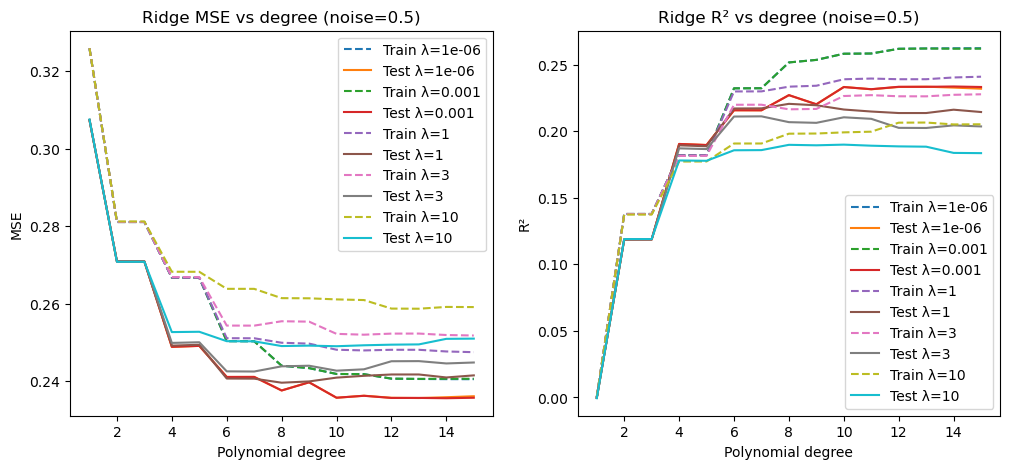

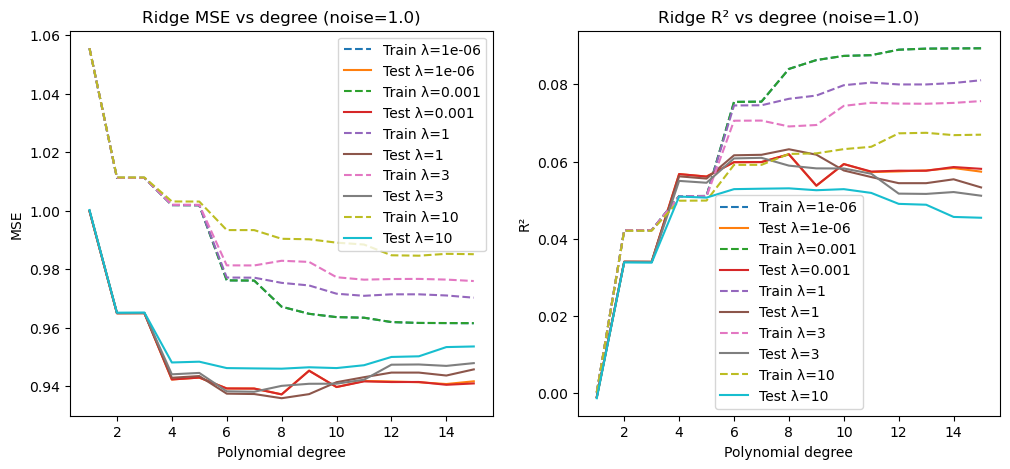

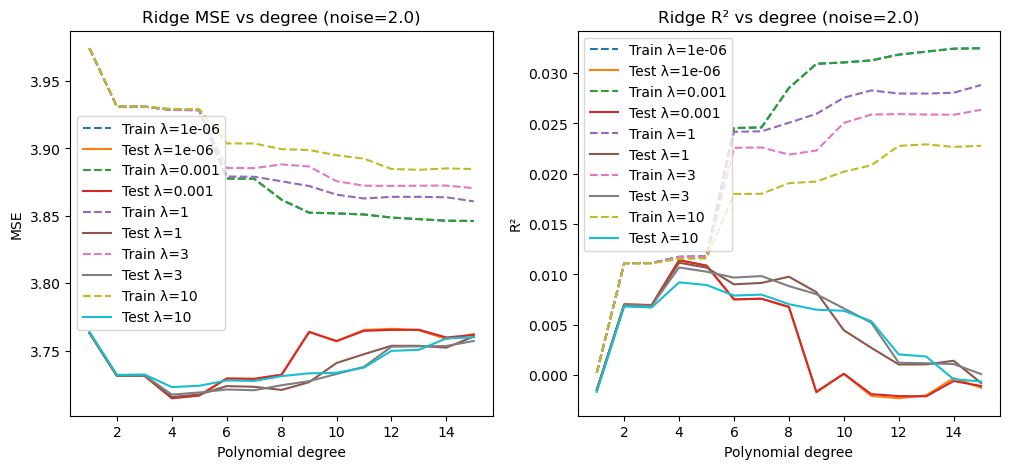

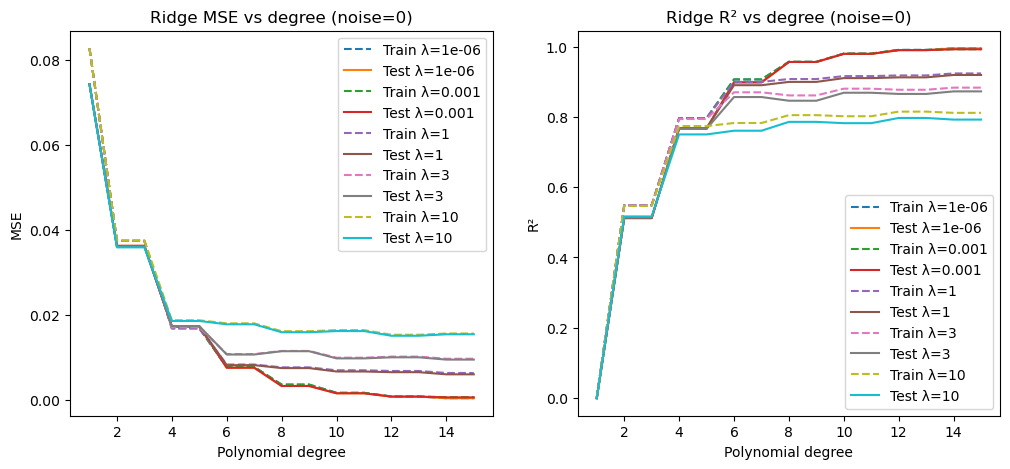

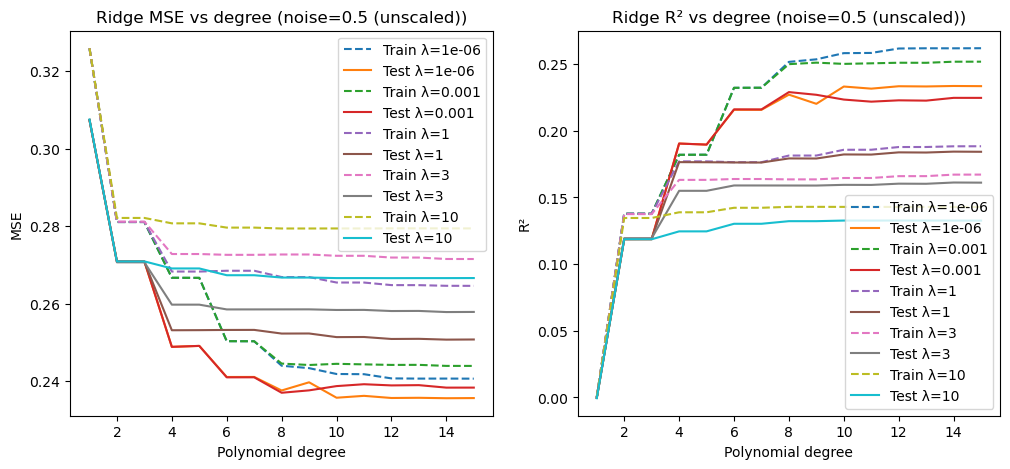

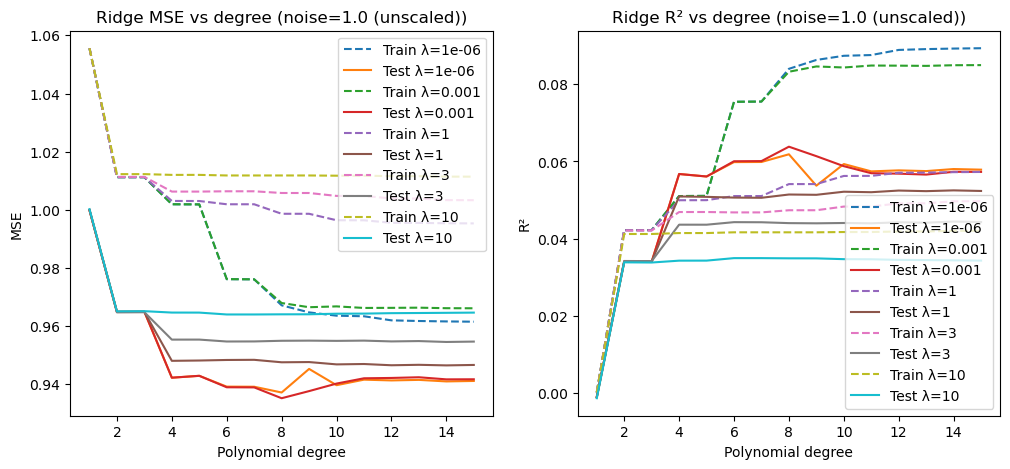

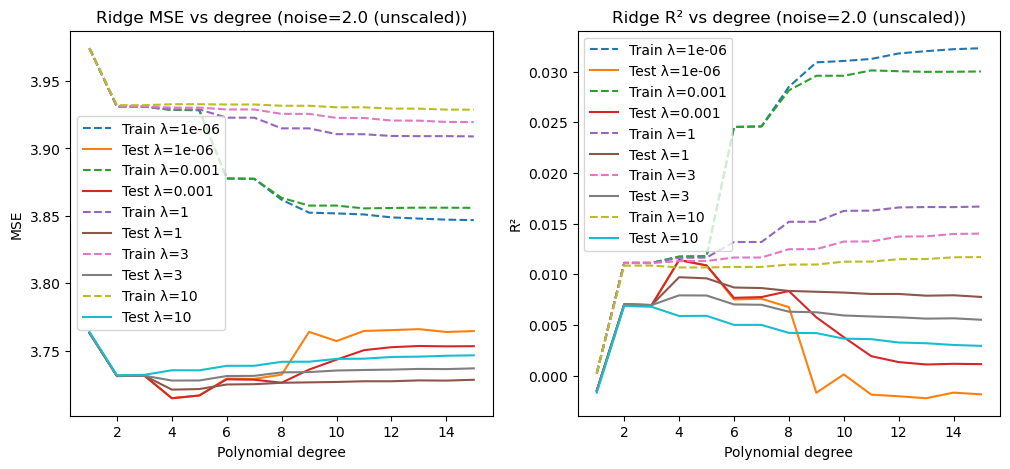

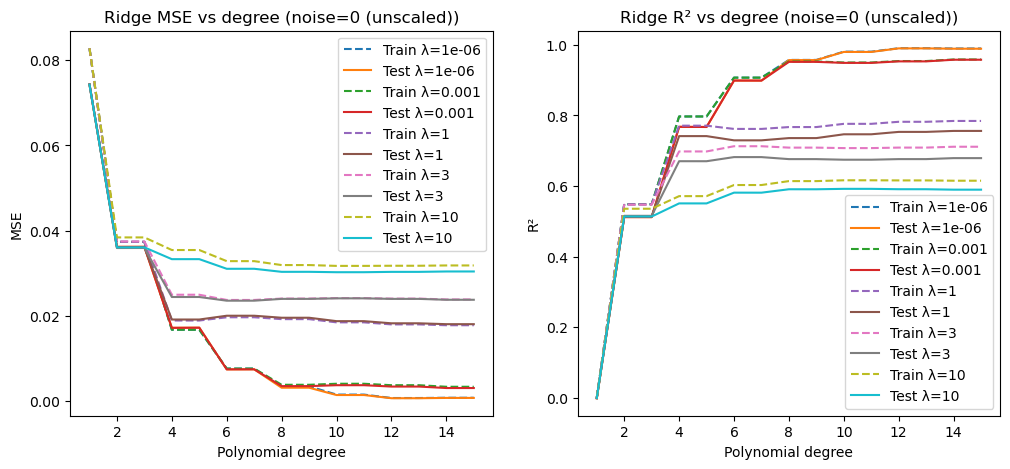

In [47]:
def design_matrix(x, degree):
    return np.vstack([x**i for i in range(degree+1)]).T

def mse(y, y_hat):
    return np.mean((y - y_hat)**2)

def r2(y, y_hat):
    return 1 - np.sum((y - y_hat)**2) / np.sum((y - np.mean(y))**2)

def ridge_fit(X, y, lam):
    n, p = X.shape
    I = np.eye(p)
    return np.linalg.pinv(X.T @ X + lam * I) @ (X.T @ y)

lambdas = [1e-6, 1e-3, 1, 3, 10]
degrees = range(1, 16)

x_train, x_test = train_test_split(x, test_size=0.2, random_state=42)


_, _, y1_train, y1_test = train_test_split(x, y_noisy1, test_size=0.2, random_state=42)
_, _, y2_train, y2_test = train_test_split(x, y_noisy2, test_size=0.2, random_state=42)
_, _, y3_train, y3_test = train_test_split(x, y_noisy3, test_size=0.2, random_state=42)
_, _, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 1)).flatten()
x_test_scaled = scaler.transform(x_test.reshape(-1, 1)).flatten()

def evaluate_Ridge(y_train, y_test, degrees, x_train_scaled, x_test_scaled, lambdas, label):
    results = {}
    for lam in lambdas:
        results[lam] = {"mse_train": [], "mse_test": [], "r2_train": [], "r2_test": []}

        for d in degrees:
            X_train = design_matrix(x_train_scaled, d)
            X_test = design_matrix(x_test_scaled, d)

            beta = ridge_fit(X_train, y_train, lam)

            y_train_hat = X_train @ beta
            y_test_hat = X_test @ beta

            results[lam]["mse_train"].append(mse(y_train, y_train_hat))
            results[lam]["mse_test"].append(mse(y_test, y_test_hat))
            results[lam]["r2_train"].append(r2(y_train, y_train_hat))
            results[lam]["r2_test"].append(r2(y_test, y_test_hat))

    # --- Plot ---
    plt.figure(figsize=(12,5))

    # MSE-plot
    plt.subplot(1,2,1)
    for lam in lambdas:
        plt.plot(degrees, results[lam]["mse_train"], "--", label=f"Train λ={lam}")
        plt.plot(degrees, results[lam]["mse_test"], label=f"Test λ={lam}")
    plt.xlabel("Polynomial degree")
    plt.ylabel("MSE")
    plt.legend()
    plt.title(f"Ridge MSE vs degree ({label})")

    # R²-plot
    plt.subplot(1,2,2)
    for lam in lambdas:
        plt.plot(degrees, results[lam]["r2_train"], "--", label=f"Train λ={lam}")
        plt.plot(degrees, results[lam]["r2_test"], label=f"Test λ={lam}")
    plt.xlabel("Polynomial degree")
    plt.ylabel("R²")
    plt.legend()
    plt.title(f"Ridge R² vs degree ({label})")

    plt.show()

evaluate_Ridge(y1_train, y1_test, degrees, x_train_scaled, x_test_scaled, lambdas, label="noise=0.5")
evaluate_Ridge(y2_train, y2_test, degrees, x_train_scaled, x_test_scaled, lambdas, label="noise=1.0")
evaluate_Ridge(y3_train, y3_test, degrees, x_train_scaled, x_test_scaled, lambdas, label="noise=2.0")
evaluate_Ridge(y_train, y_test, degrees, x_train_scaled, x_test_scaled, lambdas, label="noise=0")
evaluate_Ridge(y1_train, y1_test, degrees, x_train, x_test, lambdas, label="noise=0.5 (unscaled)")
evaluate_Ridge(y2_train, y2_test, degrees, x_train, x_test, lambdas, label="noise=1.0 (unscaled)")
evaluate_Ridge(y3_train, y3_test, degrees, x_train, x_test, lambdas, label="noise=2.0 (unscaled)")
evaluate_Ridge(y_train, y_test, degrees, x_train, x_test, lambdas, label="noise=0 (unscaled)") 

In [48]:
def evaluate_Ridge_best(y_train, y_test, degrees, x_train_scaled, x_test_scaled, lambdas, label):
    results = []
    
    for lam in lambdas:
        for d in degrees:
            X_train = design_matrix(x_train_scaled, d)
            X_test = design_matrix(x_test_scaled, d)
            
            beta = ridge_fit(X_train, y_train, lam)
            y_train_hat = X_train @ beta
            y_test_hat = X_test @ beta

            results.append({
                "lambda": lam,
                "degree": d,
                "mse_train": mse(y_train, y_train_hat),
                "mse_test": mse(y_test, y_test_hat),
                "r2_train": r2(y_train, y_train_hat),
                "r2_test": r2(y_test, y_test_hat)
            })

    
    results_df = pd.DataFrame(results)

    
    best_row = results_df.loc[results_df["mse_test"].idxmin()]

    print(f"Best Ridge result for {label}:")
    print(f"  → Degree = {best_row.degree}")
    print(f"  → λ = {best_row['lambda']}")
    print(f"  → Test MSE = {best_row.mse_test:.4f}")
    print(f"  → Train MSE = {best_row.mse_train:.4f}")
    print(f"  → Test R² = {best_row.r2_test:.4f}")
    print(f"  → Train R² = {best_row.r2_train:.4f}")

    return best_row


In [49]:
best1 = evaluate_Ridge_best(y1_train, y1_test, degrees, x_train_scaled, x_test_scaled, lambdas, "noise=0.5")
best2 = evaluate_Ridge_best(y2_train, y2_test, degrees, x_train_scaled, x_test_scaled, lambdas, "noise=1.0")
best3 = evaluate_Ridge_best(y3_train, y3_test, degrees, x_train_scaled, x_test_scaled, lambdas, "noise=2.0")
best0 = evaluate_Ridge_best(y_train, y_test, degrees, x_train_scaled, x_test_scaled, lambdas, "noise=0")
best1_u = evaluate_Ridge_best(y1_train, y1_test, degrees, x_train, x_test, lambdas, "noise=0.5 (unscaled)")   
best2_u = evaluate_Ridge_best(y2_train, y2_test, degrees, x_train, x_test, lambdas, "noise=1.0 (unscaled)")
best3_u = evaluate_Ridge_best(y3_train, y3_test, degrees, x_train, x_test, lambdas, "noise=2.0 (unscaled)")
best0_u = evaluate_Ridge_best(y_train, y_test, degrees, x_train, x_test, lambdas, "noise=0 (unscaled)")

best_results = pd.DataFrame([best0, best1, best2, best3, best0_u, best1_u, best2_u, best3_u])
best_results.index = ["noise=0", "noise=0.5", "noise=1.0", "noise=2.0", "noise=0 (unscaled)", "noise=0.5 (unscaled)", "noise=1.0 (unscaled)", "noise=2.0 (unscaled)"]
display(best_results)



Best Ridge result for noise=0.5:
  → Degree = 14.0
  → λ = 0.001
  → Test MSE = 0.2355
  → Train MSE = 0.2406
  → Test R² = 0.2336
  → Train R² = 0.2620
Best Ridge result for noise=1.0:
  → Degree = 8.0
  → λ = 1.0
  → Test MSE = 0.9358
  → Train MSE = 0.9753
  → Test R² = 0.0632
  → Train R² = 0.0762
Best Ridge result for noise=2.0:
  → Degree = 4.0
  → λ = 1e-06
  → Test MSE = 3.7147
  → Train MSE = 3.9286
  → Test R² = 0.0114
  → Train R² = 0.0117
Best Ridge result for noise=0:
  → Degree = 14.0
  → λ = 1e-06
  → Test MSE = 0.0003
  → Train MSE = 0.0003
  → Test R² = 0.9958
  → Train R² = 0.9961
Best Ridge result for noise=0.5 (unscaled):
  → Degree = 14.0
  → λ = 1e-06
  → Test MSE = 0.2355
  → Train MSE = 0.2406
  → Test R² = 0.2336
  → Train R² = 0.2619
Best Ridge result for noise=1.0 (unscaled):
  → Degree = 8.0
  → λ = 0.001
  → Test MSE = 0.9352
  → Train MSE = 0.9679
  → Test R² = 0.0638
  → Train R² = 0.0832
Best Ridge result for noise=2.0 (unscaled):
  → Degree = 4.0
  → λ 

,lambda,degree,mse_train,mse_test,r2_train,r2_test
noise=0,0.000001,14.0,0.000322,0.000315,0.996112,0.995759
noise=0.5,0.001000,14.0,0.240576,0.235538,0.262001,0.233631
noise=1.0,1.000000,8.0,0.975302,0.935827,0.076238,0.063176
noise=2.0,0.000001,4.0,3.928572,3.714675,0.011749,0.011415
noise=0 (unscaled),0.000001,12.0,0.000783,0.000735,0.990539,0.990102
noise=0.5 (unscaled),0.000001,14.0,0.240620,0.235545,0.261865,0.233610
noise=1.0 (unscaled),0.001000,8.0,0.967935,0.935185,0.083216,0.063818
noise=2.0 (unscaled),0.000001,4.0,3.928572,3.714675,0.011749,0.011415


In [50]:
!pip install seaborn


In [51]:
import seaborn as sns

def ridge_heatmap(y_train, y_test, x_train_scaled, x_test_scaled, degrees, lambdas, label):
    mse_matrix = np.zeros((len(degrees), len(lambdas)))


    for i, d in enumerate(degrees):
        X_train = design_matrix(x_train_scaled, d)
        X_test = design_matrix(x_test_scaled, d)
        for j, lam in enumerate(lambdas):
            beta = ridge_fit(X_train, y_train, lam)
            y_test_hat = X_test @ beta
            mse_matrix[i, j] = mse(y_test, y_test_hat)

  
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        mse_matrix,
        annot=True,
        fmt=".3f",
        xticklabels=lambdas,
        yticklabels=degrees,
        cmap="viridis_r"
    )
    plt.xlabel("Lambda (λ)")
    plt.ylabel("Polynomial degree")
    plt.title(f"Ridge Test-MSE Heatmap ({label})")
    plt.tight_layout()
    plt.show()

    return mse_matrix


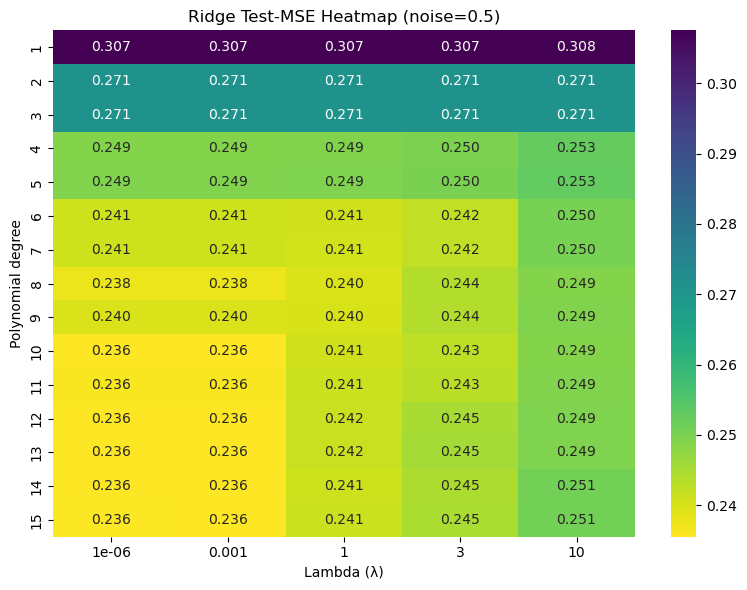

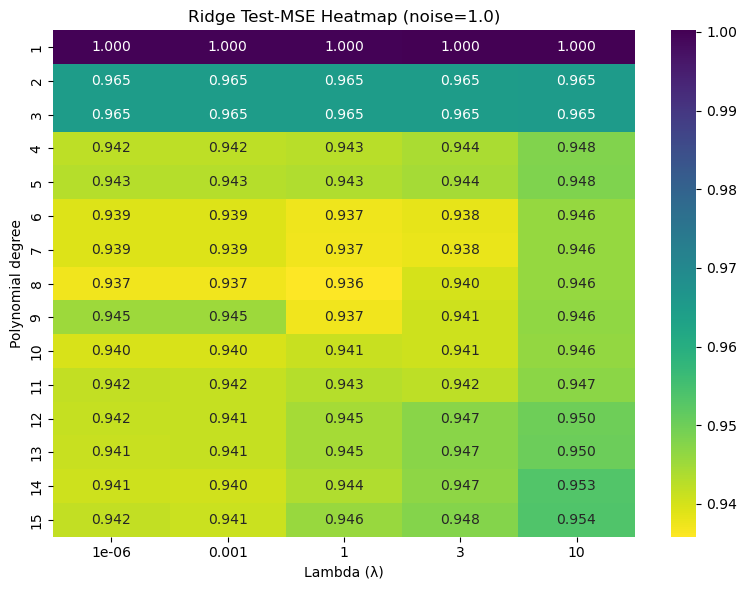

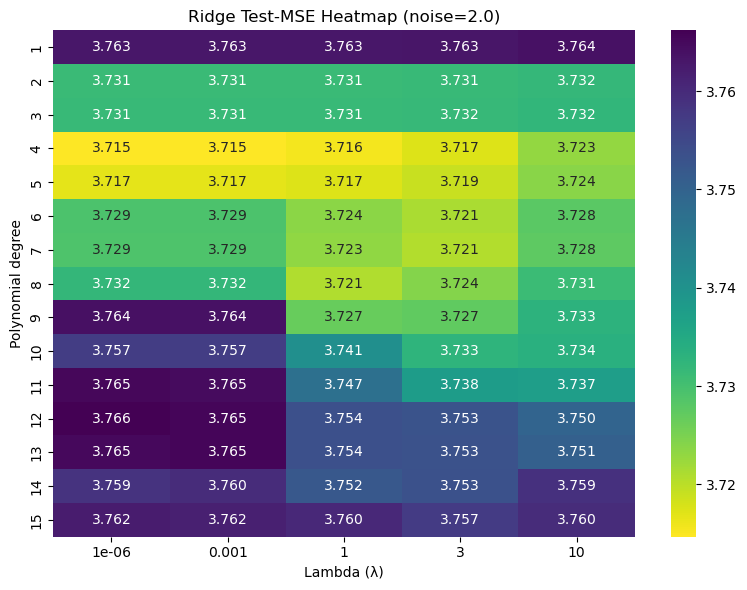

array([[3.76306875, 3.76306882, 3.76314534, 3.76329899, 3.7638415 ],
       [3.73118061, 3.73118067, 3.73124387, 3.73137978, 3.73194612],
       [3.73140541, 3.73140549, 3.73148209, 3.73164396, 3.73229289],
       [3.71467543, 3.71467636, 3.71559835, 3.71737621, 3.72294087],
       [3.71669063, 3.71669138, 3.71744637, 3.71894944, 3.72391554],
       [3.72929988, 3.72929136, 3.72367163, 3.72116052, 3.72785902],
       [3.72903886, 3.72902981, 3.72314523, 3.72059068, 3.72750321],
       [3.73215015, 3.73208751, 3.72082684, 3.72432991, 3.73108414],
       [3.7639957 , 3.76377342, 3.72658328, 3.72733344, 3.73313153],
       [3.75705611, 3.75706208, 3.74081405, 3.73264897, 3.73354386],
       [3.76532359, 3.76464781, 3.74735191, 3.73796116, 3.73743273],
       [3.76617553, 3.76539014, 3.7535724 , 3.75292394, 3.74981657],
       [3.7651382 , 3.76546828, 3.75355607, 3.7531295 , 3.75060479],
       [3.75866726, 3.7597588 , 3.75219543, 3.75342763, 3.75909517],
       [3.76224676, 3.76161919, 3.

In [52]:
ridge_heatmap(y1_train, y1_test, x_train_scaled, x_test_scaled, degrees, lambdas, "noise=0.5")
ridge_heatmap(y2_train, y2_test, x_train_scaled, x_test_scaled, degrees, lambdas, "noise=1.0")
ridge_heatmap(y3_train, y3_test, x_train_scaled, x_test_scaled, degrees, lambdas, "noise=2.0")
